In [ ]:
import os
from string import digits, ascii_lowercase
from random import shuffle, seed
from typing import Union, List, Tuple, Dict
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchmetrics import CharErrorRate
from torchvision import transforms

from PIL import Image
from IPython import display
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DIR = "drive/MyDrive/DL/samples"
BATCH_SIZE = 16
BLANK_LABEL = 0

RANDOM_SEED = 0
seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)

# Подготовка данных

Для удобства было решено подготовить LabelConverter для работы с капчей, а также класс CaptchaDataset позволяющий разделить данные на тренировочную и тестовую выборки в отношении четыре к одному.

In [ ]:
class LabelConverter:
    def __init__(self, chars: str):
        self.chars = chars
        self.chars_dimension = len(chars)
        self.char2idx = {
            char: idx for idx, char in zip(range(1, self.chars_dimension), chars)
        }
        self.idx2char = {idx: char for char, idx in self.char2idx.items()}

    def encode(
        self, labels: Union[str, List, Tuple]
    ) -> Tuple[torch.IntTensor, torch.IntTensor]:
        if isinstance(labels, str):
            labels = [labels]

        length = [len(label) for label in labels]
        labels = "".join(labels)
        labels = [self.char2idx[char] for char in labels]
        return torch.IntTensor(labels), torch.IntTensor(length)

    def decode(self, logit: torch.Tensor) -> str:
        index = logit.cpu().argmax(2)
        index = index.squeeze(1).numpy()
        chars = [self.idx2char[idx] if idx != 0 else "-" for idx in index]
        chars = "".join(chars)
        chars = chars.split("-")

        label = []
        for char in chars:
            if len(char) != 0:
                label.append(char[0])

        label = "".join(label)
        return label

In [ ]:
label_converter = LabelConverter(digits + ascii_lowercase)

In [ ]:
class CaptchaDataset(Dataset):
    def __init__(self, path: str, train: bool = True):
        self.path = path
        self.images = []
        self.labels = []
        files = os.listdir(path)
        shuffle(files)

        for image in files:
            label = image.split(".")[0]
            self.images.append(os.path.join(path, image))
            self.labels.append(label)

        if train:  # 80%
            self.images = self.images[: int(0.8 * len(self.images))]
            self.labels = self.labels[: int(0.8 * len(self.labels))]

        else:  # 20%
            self.images = self.images[int(0.8 * len(self.images)) :]
            self.labels = self.labels[int(0.8 * len(self.labels)) :]

    def __getitem__(self, index):
        path_img, label = self.images[index], self.labels[index]
        transform = transforms.Compose(
            [
                lambda x: Image.open(x).convert("RGB"),
                transforms.ToTensor(),
            ]
        )
        img = transform(path_img)

        return img, label, path_img

    def __len__(self):
        return len(self.images)

In [ ]:
train_data = CaptchaDataset(DIR, train=True)
test_data = CaptchaDataset(DIR, train=False)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
train_data.__len__(), test_data.__len__()

(856, 214)

# Создание и обучение модели

Архитектура построенной модели представляет собой комбинацию сверточной нейронной сети и двунаправленной рекуррентной нейронной сети. На выходе использовался CTCLoss. Во время цикла обучения фиксируется loss. Также в результате сравнения производительности двух одинаковых сеток с разными optimizers получилось, что Adam превосходит SGD по скорости сходимости, было решено оставить его.

In [ ]:
class CaptchaModel(nn.Module):
    def __init__(self, input_size: int, output_size: int):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(input_size, 256, (3, 3), stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, (3, 3), stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )

        self.linear = nn.Linear(3328, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.lstm = nn.LSTM(512, 256, bidirectional=True)
        self.embedding = nn.Linear(256 * 2, output_size + 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output = self.cnn(x)
        n, c, w, h = output.size()
        output = output.view(n, -1, h)
        output = output.permute(0, 2, 1)
        output = self.linear(output)

        output = output.permute(1, 0, 2)
        output, _ = self.lstm(output)
        output = self.embedding(output)

        return output

In [ ]:
def plot_loss(epoch: int, train_loss: List, test_loss: List):
    display.clear_output(True)
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].plot(train_loss)
    ax[1].plot(test_loss)

    train_title = f"Epoch:{epoch} // Train Loss:{np.mean(train_loss[-100:]):.5f}"
    test_title = f"Epoch:{epoch} // Test Loss:{np.mean(test_loss[-100:]):.5f}"
    ax[0].set_title(train_title)
    ax[1].set_title(test_title)

    plt.show()

In [ ]:
model = CaptchaModel(input_size=3, output_size=label_converter.chars_dimension).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CTCLoss(blank=BLANK_LABEL)

In [ ]:
class CaptchaRecognition:
    def __init__(
        self,
        model: CaptchaModel,
        optimizer: torch.optim.Adam,
        criterion: nn.CTCLoss,
        label_converter: LabelConverter,
        epochs: int = 50,
    ):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.label_converter = label_converter
        self.epochs = epochs
        self.device = device

    def calculate_loss(self, output: torch.Tensor, target: Tuple):
        c, n = output.size(0), output.size(1)
        output_lengths = torch.full(size=(n,), fill_value=c, dtype=torch.int32)
        target_encoded, target_lengths = self.label_converter.encode(target)
        loss = self.criterion(output, target_encoded, output_lengths, target_lengths)
        return loss

    def fit(
        self, train_loader: DataLoader, test_loader: DataLoader
    ) -> Tuple[Dict, List[float], List[float]]:
        train_history_loss = []
        test_history_loss = []
        for epoch in tqdm(range(self.epochs), total=self.epochs):
            self.model.train()
            for image, target, _ in train_loader:
                self.optimizer.zero_grad()

                image = image.to(device=self.device)
                output = self.model(image)

                train_loss = self.calculate_loss(output, target)
                train_history_loss.append(train_loss.item())
                train_loss.backward()

                self.optimizer.step()

            results, test_history_loss = self.evaluate(test_loader, test_history_loss)
            plot_loss(epoch + 1, train_history_loss, test_history_loss)

        return results, train_history_loss, test_history_loss

    def evaluate(
        self, test_loader: DataLoader, test_history_loss: List[float]
    ) -> Tuple[Dict, List[float]]:
        outputs = {"predict": [], "target": [], "image": []}

        self.model.eval()
        with torch.no_grad():
            for image, target, path_image in test_loader:
                image = image.to(device=self.device)
                output = self.model(image)

                test_loss = self.calculate_loss(output, target)
                test_history_loss.append(test_loss.item())

                outputs["predict"].append(output)
                outputs["target"].append(target)
                outputs["image"].append(path_image)

        return outputs, test_history_loss

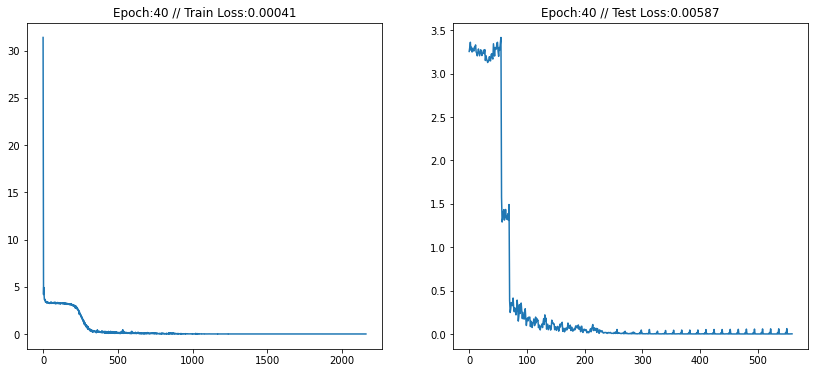

100%|██████████| 40/40 [02:08<00:00,  3.21s/it]


In [ ]:
engine = CaptchaRecognition(model, optimizer, criterion, label_converter, 40)
results, train_loss, test_loss = engine.fit(train_loader, test_loader)

In [ ]:
# saving = {
#     'state_dict': engine.model.state_dict(),
#     'optimizer': engine.optimizer.state_dict(),
#     'char2idx': label_converter.char2idx,
#     'idx2char': label_converter.idx2char,
#     }
# torch.save(saving, 'model.pth')

График функции потерь в процессе обучения стремительно снижается как для тренировочной, так и тестовой выборки. Таким образом выбранная архитектура модели обаладает хорошей обобщающей способностью. Как хорошо она справляется с задачей? Рассчитаем Character Error Rate и Accuracy.

# Подсчет метрик

In [ ]:
df_results = []
for predicts, targets, images in zip(
    results["predict"], results["target"], results["image"]
):
    for idx in range(len(images)):
        output = label_converter.decode(predicts[:, idx, :].unsqueeze(1))
        df_results.append([output, targets[idx], images[idx]])
df_results = pd.DataFrame(df_results, columns=["predict", "target", "image"])

In [ ]:
df_results

,predict,target,image
0,ycnfc,ycnfc,drive/MyDrive/DL/samples/ycnfc.png
1,nm248,nm248,drive/MyDrive/DL/samples/nm248.png
2,bxxfc,bxxfc,drive/MyDrive/DL/samples/bxxfc.png
3,excmn,excmn,drive/MyDrive/DL/samples/excmn.png
4,befbd,befbd,drive/MyDrive/DL/samples/befbd.png
...,...,...,...
209,mcc2x,mcc2x,drive/MyDrive/DL/samples/mcc2x.png
210,5nxnn,5nxnn,drive/MyDrive/DL/samples/5nxnn.png
211,cy3nw,cy3nw,drive/MyDrive/DL/samples/cy3nw.png
212,myf82,myf82,drive/MyDrive/DL/samples/myf82.png


In [ ]:
cer = CharErrorRate()
df_results['char_error_rate'] = df_results.apply(lambda x: cer(x.predict, x.target), axis=1)
print(f'Character Error Rate: {df_results.char_error_rate.mean() * 100:.2f}')
print(f'Accuracy: {(df_results.predict == df_results.target).mean() * 100:.2f}')

Character Error Rate: 0.19
Accuracy: 99.07


Качество модели хорошее, точность распознавания символов высокая, CER меньше 1%.

# Анализ ошибок модели

In [ ]:
def plot_image(data: pd.DataFrame):
    fig, ax = plt.subplots(data.shape[0], 1, figsize=(8, 5))

    for _, row in data.iterrows():
        predict, target = row["predict"], row["target"]
        img = Image.open(row["image"]).convert("RGB")

        title = f"Target: {target} // Predict: {predict}"
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")

In [ ]:
errors_test = df_results[df_results.predict != df_results.target]
print(f'Всего объектов в тестовой выборке: {df_results.shape[0]}, неверно распознанных: {errors_test.shape[0]}.')
print(errors_test['predict'].str.len().value_counts())

Всего объектов в тестовой выборке: 214, неверно распознанных: 2.
5    1
4    1
Name: predict, dtype: int64


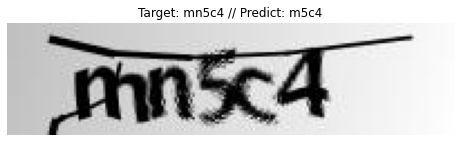

In [ ]:
errors_test_len4 = errors_test[errors_test['predict'].str.len() == 4].reset_index(drop=True)
plot_image(errors_test_len4)

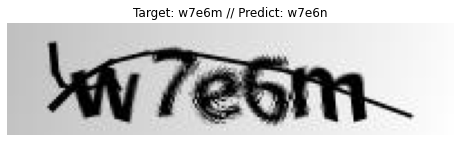

In [ ]:
errors_test_len5 = errors_test[errors_test['predict'].str.len() == 5].reset_index(drop=True)
plot_image(errors_test_len5)

Трудности возникают при распознавании "n" и "m". Контуры соседних букв очень расплывчаты и где-то пересекаются, возможно, этим были вызваны проблемы с распознаванием символов. Можно попробовать увеличить тренировочный датасет подобными примерами капч.